### **1. Data Preprocessing**
- Load images from both **CANCER** and **NON CANCER** folders.
- Resize images to **299x299** (required for InceptionResNetV2).
- Normalize pixel values to **[0,1]**.
- Apply **data augmentation** (rotation, flipping, zoom, etc.).
- Split into **Train (80%)**, **Validation (10%)**, **Test (10%)**.

### **2. Model Architecture**
- Load **InceptionResNetV2** with `imagenet` weights.
- Remove the top layer and add:
  - **GlobalAveragePooling2D**
  - **Dense(512, activation='relu')**
  - **Dropout(0.3)**
  - **Dense(1, activation='sigmoid')** (binary classification)

### **3. Training Strategy**
- **Phase 1:** Train only the custom classifier (freeze base model).
- **Phase 2:** Unfreeze top layers and fine-tune with a **low learning rate**.
- Use:
  - **Adam optimizer** (with LR scheduling)
  - **Binary Crossentropy Loss**
  - **Early stopping & checkpointing**

### **4. Evaluation & Visualization**
- Compute accuracy, precision, recall, and AUC.
- Use **Grad-CAM** to visualize model predictions.


## **Step 1: Install & Import Required Libraries**  
We'll install dependencies (if needed) and import essential libraries like TensorFlow, Keras, NumPy, Matplotlib, etc.

In [7]:
# Step 1: Install & Import Required Libraries

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
import random
from PIL import Image  # Import Pillow for image handling

## **Step 2: Load and Preprocess the Dataset**  
- Extract images from the dataset structure.
- Organize them into **training, validation, and test sets**.
- Apply **image augmentation** to improve generalization.
- Resize images to **299x299** (InceptionResNetV2 input size).
- Normalize pixel values to **[0,1]**.

In [8]:
import zipfile
import os

zip_path = "./ocd.zip"  # Ensure this matches your file location
extract_path = "./ocd"

# Extract the zip file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")
print("Extracted files:", os.listdir(extract_path))

Extraction complete!
Extracted files: ['Oral Cancer', 'Oral cancer Dataset 2.0']


In [9]:
### Step 2: Load and Preprocess Dataset

# Define dataset paths
data_dir = "./ocd"  # Change this to the actual path
train_dir = os.path.join(data_dir, "Oral Cancer/Oral Cancer Dataset")
test_dir = os.path.join(data_dir, "Oral cancer Dataset 2.0/OC Dataset kaggle new")

# Define parameters
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting into 80% train, 20% validation
)

# Load images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

class SafeImageDataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        gen = super().flow_from_directory(directory, *args, **kwargs)
        valid_filenames = []

        for filename in gen.filenames:
            file_path = os.path.join(directory, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Ensure it's a valid image
                valid_filenames.append(filename)
            except Exception as e:
                print(f"Skipping corrupt image: {file_path} - {e}")

        gen.filenames = valid_filenames
        gen.samples = len(valid_filenames)
        return gen

# Use this instead of the standard ImageDataGenerator
test_datagen = SafeImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust based on your model input
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 600 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 950 images belonging to 2 classes.
Skipping corrupt image: ./ocd\Oral cancer Dataset 2.0/OC Dataset kaggle new\CANCER\101.jpeg - cannot identify image file 'E:\\edp-final-pakka\\ocd\\Oral cancer Dataset 2.0\\OC Dataset kaggle new\\CANCER\\101.jpeg'
Skipping corrupt image: ./ocd\Oral cancer Dataset 2.0/OC Dataset kaggle new\CANCER\200.jpeg - cannot identify image file 'E:\\edp-final-pakka\\ocd\\Oral cancer Dataset 2.0\\OC Dataset kaggle new\\CANCER\\200.jpeg'
Skipping corrupt image: ./ocd\Oral cancer Dataset 2.0/OC Dataset kaggle new\CANCER\273.jpeg - cannot identify image file 'E:\\edp-final-pakka\\ocd\\Oral cancer Dataset 2.0\\OC Dataset kaggle new\\CANCER\\273.jpeg'
Skipping corrupt image: ./ocd\Oral cancer Dataset 2.0/OC Dataset kaggle new\CANCER\317.jpeg - cannot identify image file 'E:\\edp-final-pakka\\ocd\\Oral cancer Dataset 2.0\\OC Dataset kaggle new\\CANCER\\317.jpeg'
Skipping corrupt imag

## **Step 3: Load InceptionResNetV2 Model**  
- Load **InceptionResNetV2** with pre-trained **ImageNet** weights.
- Remove the top classification layer.
- Add **custom dense layers** for binary classification.

In [9]:
# Load pre-trained model without the top layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze base model for initial training

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

219055592/219055592 [==============================] - 1446s 7us/step


## **Step 4: Compile and Train the Model**  
- **Phase 1:** Train only the new classifier layers (freeze base layers).
- **Phase 2:** Unfreeze the top layers and fine-tune the entire model.
- Use **Adam optimizer**, **binary cross-entropy loss**, and **early stopping**.

In [10]:
### Step 4: Train the Model

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train Phase 1 (only new layers)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tuning Phase 2 (unfreeze some layers)
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
12/19 [=================>............] - ETA: 25s - loss: 1.0715 - accuracy: 0.5990

c:\Users\Jasmine Jayaswal\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


19/19 [==============================] - ETA: 0s - loss: 0.8546 - accuracy: 0.6717

c:\Users\Jasmine Jayaswal\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 100s 5s/step - loss: 0.8546 - accuracy: 0.6717 - val_loss: 0.6981 - val_accuracy: 0.6867
Epoch 2/10
19/19 [==============================] - 102s 5s/step - loss: 0.4131 - accuracy: 0.8300 - val_loss: 0.6685 - val_accuracy: 0.6867
Epoch 3/10
19/19 [==============================] - 106s 6s/step - loss: 0.3578 - accuracy: 0.8650 - val_loss: 0.5579 - val_accuracy: 0.7133
Epoch 4/10
19/19 [==============================] - 104s 6s/step - loss: 0.3178 - accuracy: 0.8717 - val_loss: 0.5556 - val_accuracy: 0.7333
Epoch 5/10
19/19 [==============================] - 103s 5s/step - loss: 0.3289 - accuracy: 0.8617 - val_loss: 0.5599 - val_accuracy: 0.7733
Epoch 6/10
19/19 [==============================] - 106s 6s/step - loss: 0.2743 - accuracy: 0.9000 - val_loss: 0.5312 - val_accuracy: 0.7400
Epoch 7/10
19/19 [==============================] - 107s 6s/step - loss: 0.2934 - accuracy: 0.8883 - val_loss: 0.4391 - val_accuracy: 0.8267
Epoch 8/10
19/19 [======

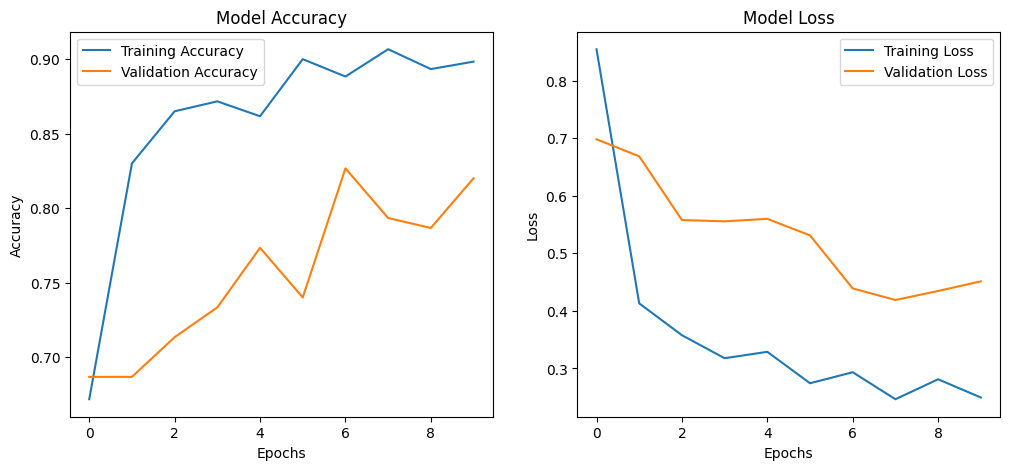

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()


## **Step 5: Model Evaluation**  
- Evaluate performance using **accuracy, precision, recall, and AUC**.
- Plot **training loss vs. validation loss** and **confusion matrix**.
- Use **Grad-CAM** to visualize which image regions influenced predictions.

In [20]:
from PIL import Image
import os

def check_corrupt_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)  # Try to open the image
                img.verify()  # Check if the image is valid
            except (IOError, OSError):
                print(f"Corrupt image found: {file_path}")
                os.remove(file_path)  # Remove the corrupt image

# Check train and test directories
check_corrupt_images("./ocd/Oral Cancer/Oral Cancer Dataset")
check_corrupt_images("./ocd/oral Cancer dataset 2.0/OC Dataset kaggle new")
print("Corrupt images removed!")

Corrupt image found: ./ocd/oral Cancer dataset 2.0/OC Dataset kaggle new\CANCER\101.jpeg
Corrupt images removed!


In [21]:
def convert_images_to_jpeg(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                if img.format not in ["JPEG", "JPG"]:
                    img.convert("RGB").save(file_path, "JPEG")
            except Exception as e:
                print(f"Error converting {file_path}: {e}")

convert_images_to_jpeg("./ocd/Oral Cancer/Oral Cancer Dataset")
convert_images_to_jpeg("./ocd/oral Cancer dataset 2.0/OC Dataset kaggle new")
print("All images converted to JPEG format!")


All images converted to JPEG format!


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Evaluate the Model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Step 2: Predictions
predictions = model.predict(test_generator)
pred_labels = (predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1
true_labels = test_generator.classes  # Ground truth labels

# Step 3: Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Cancer', 'Cancer'], yticklabels=['Non-Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Classification Report
print(classification_report(true_labels, pred_labels, target_names=['Non-Cancer', 'Cancer']))


NameError: name 'model' is not defined

In [1]:
   import tensorflow as tf
   import tensorflowjs as tfjs  # This is the correct import

   # Load your Keras model
   model = tf.keras.models.load_model('best_model.h5')
   
   # Convert to TensorFlow.js format
   tfjs.converters.save_keras_model(model, 'tfjs_model')

NameError: name 'tfjs' is not defined